## Imports:

In [1]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token can be pasted using 'Right-Click'.


Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to C:\Users\mehas\.cache\huggingface\token
Login successful


In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers , regularizers
from tensorflow.keras.callbacks import EarlyStopping
from transformers import DataCollatorWithPadding , PushToHubCallback

In [3]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [5]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
import warnings
warnings.filterwarnings("ignore")

## Importing Data:

In [7]:
data = pd.read_csv('all-data.csv',encoding='unicode_escape',names=['sentiment', 'text'])

## Exploratory Data Analysis (EDA):

In [8]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [10]:
data_dist = data['sentiment'].value_counts()

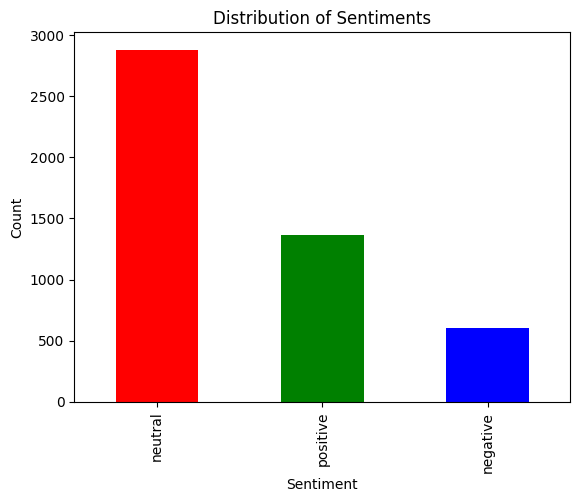

In [11]:
data_dist.plot(kind='bar',color=['red','green','blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

In [12]:
X,y = list(data['text']),data['sentiment']

In [13]:
data['tokenized_sent'] = data['text'].apply(word_tokenize)
data['num_words'] = data['tokenized_sent'].apply(len)

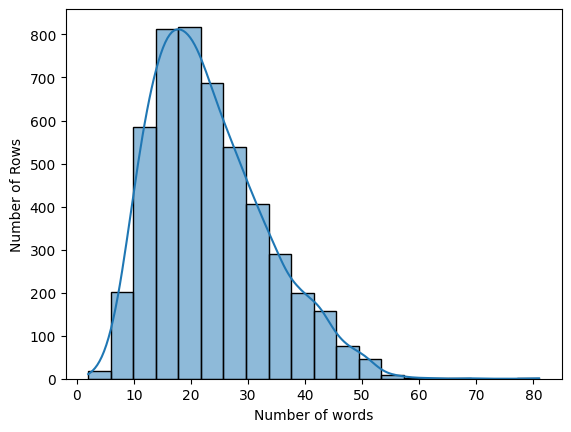

In [14]:
sns.histplot(x='num_words',data=data,bins=20,kde=True)
plt.xlabel('Number of words')
plt.ylabel('Number of Rows')
plt.show()

In [15]:
max_words = max(len(tokens) for tokens in data['tokenized_sent'])
total_words = sum(len(data) for data in data['tokenized_sent'])
average_words = total_words / len(X)

print("Maximum number of words:", max_words)
print(f"Average number of words: {average_words:.2f}")


Maximum number of words: 81
Average number of words: 23.15


## Custom Model:
    1. Using Static Embeddings:

#### Data Preprocessing:

Label Encoding the target variable:

In [16]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit(y)
y_enc = label_encoder.transform(y)

In [17]:
y_enc

array([1, 1, 0, ..., 0, 0, 0])

Tokenizing and padding the sequences:

In [18]:
max_words = 1000
max_len = 55
tokenizer = Tokenizer(num_words=max_words,oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_seq = pad_sequences(sequences,padding='post',maxlen=max_len,truncating='post')


Splitting data into training and testing datasets:

In [19]:
train_data,test_data,train_label,test_label = train_test_split(padded_seq,y_enc,stratify=y_enc,test_size=0.3,random_state=42)

In [20]:
train_data.shape , train_label.shape

((3392, 55), (3392,))

 Configuring the Early Stopping Strategy:

In [21]:

early_stop = EarlyStopping(monitor='val_accuracy',patience=5)

Setting Up the Sequential Model:

In [22]:
model = tf.keras.Sequential()

In [23]:
model.add(layers.Embedding(input_dim=max_words,output_dim=64,input_length=max_len,mask_zero=True))
# TransfromerEncoder:
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(25,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(3,activation='softmax'))

In [24]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),loss='sparse_categorical_crossentropy',metrics=["accuracy"])

In [25]:
history1 = model.fit(train_data,train_label,epochs=25,validation_split=0.2,batch_size=25,callbacks=[early_stop])

Epoch 1/25


109/109 [==============================] - 4s 18ms/step - loss: 1.3216 - accuracy: 0.5827 - val_loss: 1.1812 - val_accuracy: 0.6186
Epoch 2/25
109/109 [==============================] - 1s 12ms/step - loss: 1.1656 - accuracy: 0.5879 - val_loss: 1.0898 - val_accuracy: 0.6215
Epoch 3/25
109/109 [==============================] - 1s 11ms/step - loss: 1.0875 - accuracy: 0.6060 - val_loss: 1.0190 - val_accuracy: 0.6495
Epoch 4/25
109/109 [==============================] - 1s 11ms/step - loss: 1.0217 - accuracy: 0.6377 - val_loss: 0.9603 - val_accuracy: 0.6583
Epoch 5/25
109/109 [==============================] - 1s 11ms/step - loss: 0.9652 - accuracy: 0.6506 - val_loss: 0.9101 - val_accuracy: 0.6745
Epoch 6/25
109/109 [==============================] - 1s 12ms/step - loss: 0.9030 - accuracy: 0.6679 - val_loss: 0.8741 - val_accuracy: 0.6701
Epoch 7/25
109/109 [==============================] - 1s 12ms/step - loss: 0.8493 - accuracy: 0.6834 - val_loss: 0.8393 - val_accuracy: 0.68

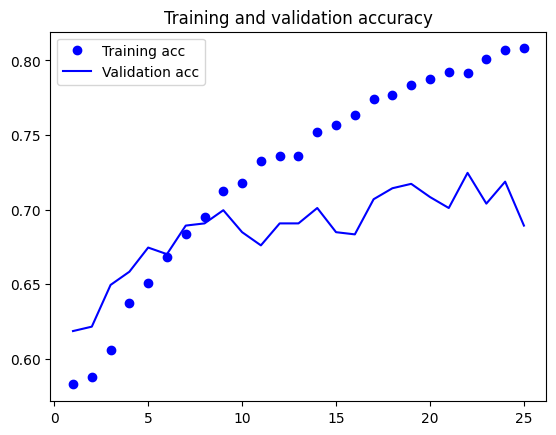

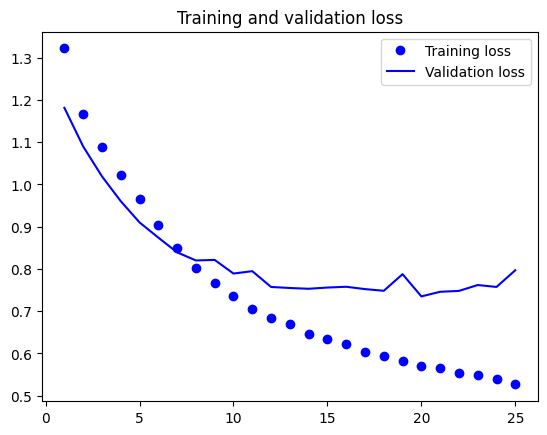

In [26]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Evaluating the model on testing dataset:

In [27]:
loss, customMod_acc = model.evaluate(test_data,test_label)
print(f"Accuracy:{customMod_acc:.2f}")

46/46 [==============================] - 0s 4ms/step - loss: 0.8911 - accuracy: 0.6623
Accuracy:0.66


## Direct Inferencing DistilRoBerta and Evaluating on testing data set:

In [28]:
from datasets import Dataset


In [29]:
checkpoint="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [30]:
encoder = LabelEncoder()
data = pd.read_csv('all-data.csv',encoding = 'unicode_escape',names=['sentiments' ,'text'])
data['labels'] = encoder.fit_transform(data['sentiments'])

In [31]:

def tokenization_func(data):
    return tokenizer(data['text'],truncation=True)

In [32]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [33]:
def stratified_split(data, random_state=42):
        
    training_data, remaining_data = train_test_split(data, test_size=0.5, random_state=random_state)
    val_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=random_state)

    train_dataset = Dataset.from_pandas(training_data)
    val_dataset = Dataset.from_pandas(val_data)
    test_dataset = Dataset.from_pandas(test_data)
    return train_dataset, val_dataset, test_dataset

In [34]:
train,val,test = stratified_split(data[['text','labels']])

In [35]:
tokenized_train = train.map(tokenization_func,batched=True)
tokenized_val = val.map(tokenization_func,batched=True)
tokenized_test = test.map(tokenization_func,batched=True)

Map:   0%|          | 0/2423 [00:00<?, ? examples/s]

Map:   0%|          | 0/1211 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

In [36]:
tf_train_dataset = tokenized_train.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=25,
    collate_fn=data_collator
    )
# token_type_ids
tf_validation_dataset = tokenized_val.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=25,
    collate_fn=data_collator
    )
tf_test_dataset = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=25,
    collate_fn=data_collator
    )

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [37]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=["accuracy"])

In [38]:
_,Roberta_Acc = model.evaluate(tf_test_dataset)

49/49 [==============================] - 19s 297ms/step - loss: 0.8546 - accuracy: 0.8672


In [39]:
print(f"Accuracy Yielded by Distil-Roberta : {Roberta_Acc:.2f}")

Accuracy Yielded by Distil-Roberta : 0.87


## FineTuning & Inferencing Finbert:

In [40]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [42]:
checkpoint="ProsusAI/finbert"

In [43]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
def tokenization_func(data):
    return tokenizer(data['text'],truncation=True)

In [45]:
tokenized_train = train.map(tokenization_func,batched=True)
tokenized_val = val.map(tokenization_func,batched=True)
tokenized_test = test.map(tokenization_func,batched=True)

Map:   0%|          | 0/2423 [00:00<?, ? examples/s]

Map:   0%|          | 0/1211 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

In [46]:
tf_train_dataset = tokenized_train.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=25,
    collate_fn=data_collator
    )
# token_type_ids
tf_validation_dataset = tokenized_val.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=25,
    collate_fn=data_collator
    )
tf_test_dataset = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=25,
    collate_fn=data_collator
    )

In [47]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [48]:
_,finbert_acc = model.evaluate(tf_test_dataset)

49/49 [==============================] - 34s 601ms/step - loss: 0.8795 - accuracy: 0.8870


In [49]:
history2 = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    batch_size = 4,
    epochs=5
    )

Epoch 1/5
97/97 [==============================] - 288s 3s/step - loss: 0.5018 - accuracy: 0.8803 - val_loss: 0.3382 - val_accuracy: 0.8927
Epoch 2/5
97/97 [==============================] - 274s 3s/step - loss: 0.2365 - accuracy: 0.9356 - val_loss: 0.2961 - val_accuracy: 0.8935
Epoch 3/5
97/97 [==============================] - 271s 3s/step - loss: 0.1278 - accuracy: 0.9674 - val_loss: 0.3057 - val_accuracy: 0.8893
Epoch 4/5
97/97 [==============================] - 275s 3s/step - loss: 0.0741 - accuracy: 0.9827 - val_loss: 0.3580 - val_accuracy: 0.8885
Epoch 5/5
97/97 [==============================] - 264s 3s/step - loss: 0.0414 - accuracy: 0.9930 - val_loss: 0.3738 - val_accuracy: 0.8885


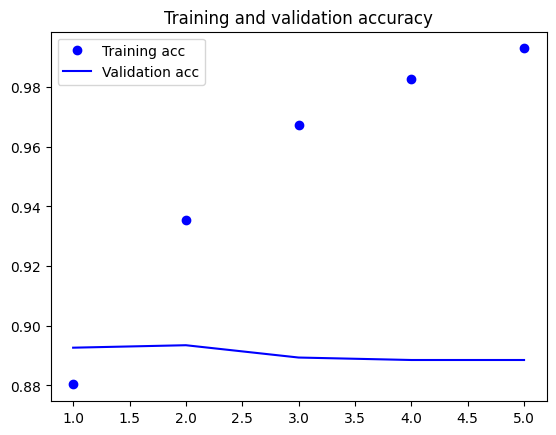

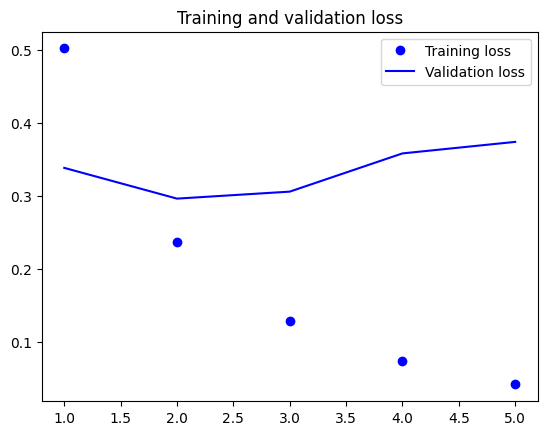

In [50]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
_ , finetuned_accuracy = model.evaluate(tf_test_dataset)

49/49 [==============================] - 28s 575ms/step - loss: 0.3616 - accuracy: 0.8919


In [52]:
pred=model.predict(tf_test_dataset)["logits"]

49/49 [==============================] - 30s 582ms/step


In [53]:
class_preds = np.argmax(pred, axis=1)
print(pred.shape, class_preds.shape)

(1212, 3) (1212,)


In [54]:
print(classification_report(tokenized_test['labels'],class_preds))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       140
           1       0.92      0.91      0.92       716
           2       0.87      0.83      0.85       356

    accuracy                           0.89      1212
   macro avg       0.87      0.90      0.88      1212
weighted avg       0.89      0.89      0.89      1212



In [56]:
# tf.math.softmax(pred.logits,axis=-1)
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [57]:
comparative_analysis = pd.DataFrame({
    "custom_built":[customMod_acc],
    "RoBerta":[Roberta_Acc],
    "Finbert":[finbert_acc],
    "fineTuned_finbert":[finetuned_accuracy]
})

In [58]:
comparative_analysis = comparative_analysis.T.reset_index()
comparative_analysis.columns = ['Model', 'Accuracy']

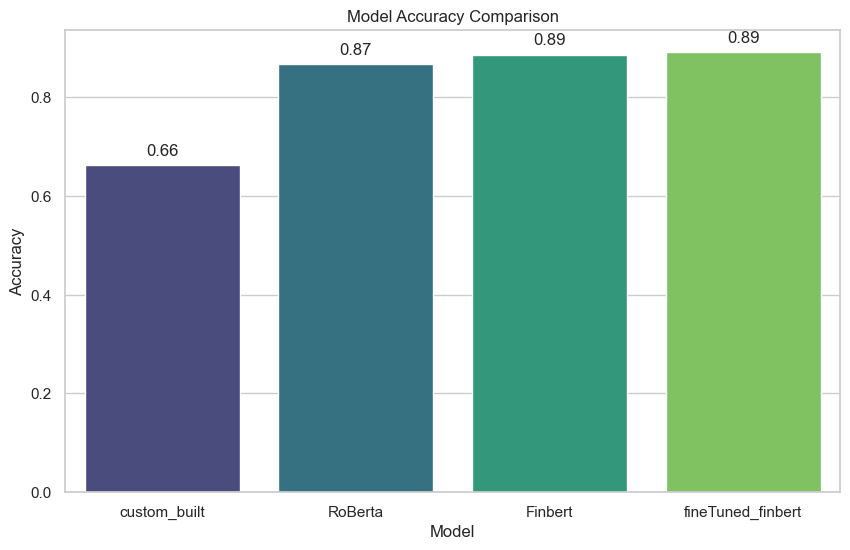

In [59]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Accuracy', data=comparative_analysis, palette="viridis")
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

R

In [60]:
callback = PushToHubCallback(
    "finbert-finetuned", save_strategy="epoch", tokenizer=tokenizer
)

Cloning https://huggingface.co/mehassan/finbert-finetuned into local empty directory.


In [61]:
data = pd.read_csv('all-data.csv',encoding = 'unicode_escape',names=['sentiments' ,'text'])
d1 = data[data["sentiments"]=="neutral"][:604]
d2 = data[data["sentiments"]=="positive"][:604]
d3 = data[data["sentiments"]=="negative"]
data = pd.concat([d1,d2,d3]).reset_index(drop=True)
data['labels'] = encoder.fit_transform(data['sentiments'])


checkpoint="ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

def tokenization_func(data):
    return tokenizer(data['text'],truncation=True)

def tokenization_func(data):
    return tokenizer(data['text'],truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
def stratified_split(data, random_state=42):
        
    training_data, remaining_data = train_test_split(data, test_size=0.5, random_state=random_state)
    val_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=random_state)

    train_dataset = Dataset.from_pandas(training_data)
    val_dataset = Dataset.from_pandas(val_data)
    test_dataset = Dataset.from_pandas(test_data)
    return train_dataset, val_dataset, test_dataset
train,val,test = stratified_split(data[['text','labels']])
tokenized_train = train.map(tokenization_func,batched=True)
tokenized_val = val.map(tokenization_func,batched=True)
tokenized_test = test.map(tokenization_func,batched=True)
tf_train_dataset = tokenized_train.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=25,
    collate_fn=data_collator
    )
# token_type_ids
tf_validation_dataset = tokenized_val.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=25,
    collate_fn=data_collator
    )
tf_test_dataset = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=25,
    collate_fn=data_collator
    )
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
_,finbert_acc = model.evaluate(tf_test_dataset)
history2 = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    batch_size = 4,
    epochs=5,
    callbacks=[callback]
    )

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/906 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


19/19 [==============================] - 14s 565ms/step - loss: 1.0923 - accuracy: 0.3223
Epoch 1/5
37/37 [==============================] - 126s 3s/step - loss: 0.7467 - accuracy: 0.7594 - val_loss: 0.4961 - val_accuracy: 0.9227
Epoch 2/5
37/37 [==============================] - 118s 3s/step - loss: 0.3946 - accuracy: 0.9415 - val_loss: 0.3161 - val_accuracy: 0.9272
Epoch 3/5
37/37 [==============================] - 117s 3s/step - loss: 0.2334 - accuracy: 0.9592 - val_loss: 0.2575 - val_accuracy: 0.9227
Epoch 4/5
37/37 [==============================] - 118s 3s/step - loss: 0.1492 - accuracy: 0.9790 - val_loss: 0.2467 - val_accuracy: 0.9205
Epoch 5/5
37/37 [==============================] - 114s 3s/step - loss: 0.1011 - accuracy: 0.9890 - val_loss: 0.2448 - val_accuracy: 0.9205


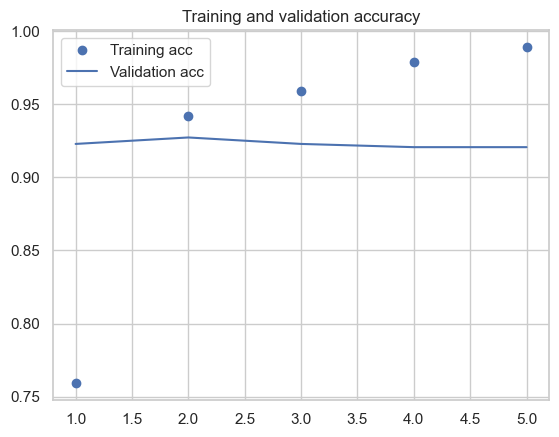

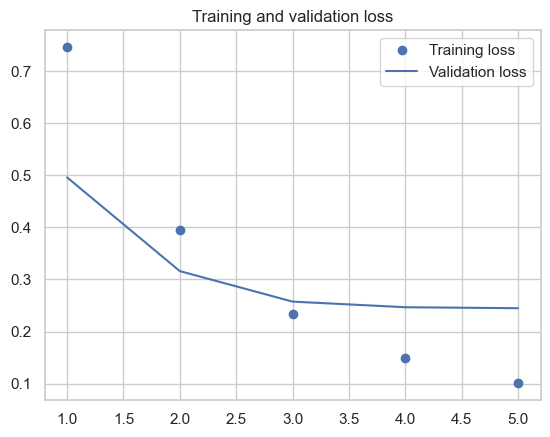

In [62]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [63]:
_ , finetuned_accuracy = model.evaluate(tf_test_dataset)
pred=model.predict(tf_test_dataset)["logits"]

19/19 [==============================] - 13s 585ms/step


In [64]:
class_preds = np.argmax(pred, axis=1)
print(pred.shape, class_preds.shape)
print(classification_report(tokenized_test['labels'],class_preds))

(453, 3) (453,)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       149
           1       0.98      0.85      0.91       165
           2       0.86      0.96      0.91       139

    accuracy                           0.93       453
   macro avg       0.93      0.93      0.93       453
weighted avg       0.94      0.93      0.93       453



In [65]:
model.save_pretrained('./finbert_finetuned_balance')